# Dataset Information Creation
Create a json file to represent the files inside the dataset

In [17]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import numpy as np
import json
import torch.nn as nn
import os
from birdlib import utils

In [18]:
# sudo modprobe nvidia_uvm
torch.cuda.is_available()

True

In [19]:
DATASET_NAME = "dataset"
MODEL_NAME = 'CustomCNN'
DATASET_VAR = 'custom'

In [20]:
DATASET_PATH = f'../segments/{DATASET_NAME}'
TRAIN_PATH = f"{DATASET_PATH}/train"
VALID_PATH = f"{DATASET_PATH}/valid"
TEST_PATH = f"{DATASET_PATH}/test"
MODEL_PATH = f'./models/{MODEL_NAME}'

# Create Dataset Config

In [21]:
def create_dataset_config(dataset_name, config_file_name='dataset_config.json'):
    saving_path = f"utils/{dataset_name}/{config_file_name}"
    if os.path.exists(saving_path):
        print("Dataset config already created!")
        with open(saving_path) as f:
            return json.load(f)

    mappings = utils.get_mappings(TRAIN_PATH)
    samples = utils.collect_samples(TRAIN_PATH, VALID_PATH, TEST_PATH, mappings)

    dataset_config = {
        "mappings": mappings,
        "samples": samples
    }
    with open(saving_path, "w") as f:
        json.dump(dataset_config, f)
    print("Saved new dataset config")
    return dataset_config

In [ ]:
dataset_config = create_dataset_config(DATASET_NAME, f'dataset_config_{DATASET_VAR}.json')
mappings = dataset_config["mappings"]

Saved new dataset config


## Load the model

In [7]:
INPUT_SHAPE = (256, 256)

config_file = f'/home/giacomoschiavo/finetuning-BirdNET/models/CustomCNN/model_ranking_config_6_0.json'
with open(config_file) as f:
    configs = json.load(f)

In [8]:
configs

[{'model_id': 19,
  'config': {'num_conv_layers': 4,
   'kernel_sizes': [4, 5, 6, 6],
   'channels': [16, 32, 64, 128],
   'batch_size': 128,
   'dropout': 0.0,
   'dense_hidden': 128},
  'micro_f1': 0.01678627904147914,
  'weighted_f1': 0.029839708730654717,
  'samples_f1': 0.006456303620764868,
  'mean_f1': 0.01769409713096624},
 {'model_id': 5,
  'config': {'num_conv_layers': 4,
   'kernel_sizes': [3, 4, 6, 6],
   'channels': [16, 32, 64, 128],
   'batch_size': 64,
   'dropout': 0.0,
   'dense_hidden': 64},
  'micro_f1': 0.016910069177555727,
  'weighted_f1': 0.028214908264909272,
  'samples_f1': 0.0072415297368038384,
  'mean_f1': 0.01745550239308961},
 {'model_id': 7,
  'config': {'num_conv_layers': 4,
   'kernel_sizes': [2, 5, 6, 6],
   'channels': [16, 32, 64, 128],
   'batch_size': 64,
   'dropout': 0.5,
   'dense_hidden': 64},
  'micro_f1': 0.015288394718554551,
  'weighted_f1': 0.02866390430004854,
  'samples_f1': 0.006228491105617759,
  'mean_f1': 0.016726930041406952},
 {'m

In [9]:
model_class = utils.load_model_class(MODEL_NAME)
model = model_class((256, 256), configs[0]['config'], len(mappings))


In [10]:
batch_size = configs[0]['config']['batch_size']

# Spectograms Creation

In [11]:
SPECS_TRAIN_PATH = f"{DATASET_PATH}/train_specs"
SPECS_VALID_PATH = f"{DATASET_PATH}/valid_specs"
SPECS_TEST_PATH = f"{DATASET_PATH}/test_specs"
os.makedirs(SPECS_TRAIN_PATH, exist_ok=True)
os.makedirs(SPECS_VALID_PATH, exist_ok=True)
os.makedirs(SPECS_TEST_PATH, exist_ok=True)
utils.specs_generation(TRAIN_PATH, SPECS_TRAIN_PATH, dataset_config['mappings'])
utils.specs_generation(VALID_PATH, SPECS_VALID_PATH, dataset_config['mappings'])
utils.specs_generation(TEST_PATH, SPECS_TEST_PATH, dataset_config['mappings'])

Processing: Aeroplane
Processing: Muscicapa striata_Spotted Flycatcher
Processing: Periparus ater_Coal Tit
Processing: Regulus regulus_Goldcrest
Processing: Anthus trivialis_Tree Pipit
Processing: Vegetation
Processing: Troglodytes troglodytes_Eurasian Wren
Processing: Erithacus rubecula_European Robin
Processing: None
Processing: Parus major_Great Tit
Processing: Certhia familiaris_Eurasian Treecreeper
Processing: Phylloscopus collybita_Common Chiffchaff
Processing: Coccothraustes coccothraustes_Hawfinch
Processing: Wind
Processing: Turdus merula_Eurasian Blackbird
Processing: Loxia curvirostra_Common Crossbill
Processing: Regulus ignicapilla_Common Firecrest
Processing: Sylvia atricapilla_Eurasian Blackcap
Processing: Lophophanes cristatus_Crested Tit
Processing: Fringilla coelebs_Common Chaffinch
Processing: Aeroplane
Processing: Muscicapa striata_Spotted Flycatcher
Processing: Periparus ater_Coal Tit
Processing: Regulus regulus_Goldcrest
Processing: Anthus trivialis_Tree Pipit
Proc

'✅ Spettrogrammi generati e salvati.'

# Model

In [ ]:
def train_model(dataset_config, model, model_name, dataset_var, epochs=10, batch_size=100, lr=1e-5, patience=3, early_stop_patience=15, print_freq=100, load_weights=False):
    history_loss = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training {model_name} on: {device}")

    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=patience
    )
    history_loss = []
    history_valid_loss = []
    best_loss = float("inf")

    saving_path = f'models/{model_name}/{dataset_var}/checkpoint.pth'
    if load_weights:
        if not os.path.exists(saving_path):
            print("No weights found!")
            return None
        checkpoint = torch.load(saving_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        history_loss = checkpoint['history_loss']
        history_valid_loss = checkpoint['history_valid_loss']
        best_loss = checkpoint['best_loss']
        starting_epoch = len(history_loss)
        print(f"Model Loaded!")
        
    print("Loading training data...")
    train_loader, valid_loader = utils.get_dataloader(dataset_config, split="train", batch_size=batch_size, split_ratio=0.15)
    print("Loaded!")
    
    model.train()
    early_stop_counter = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        print(f"\n🎯 Starting epoch {epoch + 1}/{epochs}")

        for batch_index, (mel_spec, labels, _) in enumerate(train_loader):
            mel_spec = mel_spec.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(mel_spec)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if batch_index % print_freq == 0:
                print('Epoch: [{0}][{1}/{2}], Loss: {loss:.5f}'.format(epoch, batch_index, len(train_loader), loss=loss))

        train_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.5f}")

        # Validation phase
        model.eval()
        with torch.no_grad():
            valid_loss = 0.0
            for mel_spec, labels, _ in valid_loader:
                mel_spec = mel_spec.to(device)
                labels = labels.to(device)
                outputs = model(mel_spec)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

            valid_loss /= len(valid_loader)
        
        history_loss.append(train_loss)
        history_valid_loss.append(valid_loss)
        scheduler.step(valid_loss)
        
        np.save(f'models/{model_name}/{dataset_var}/history_loss.npy', history_loss)
        np.save(f'models/{model_name}/{dataset_var}/history_valid_loss.npy', history_valid_loss)
        if valid_loss < best_loss:
            best_loss = valid_loss
            early_stop_counter = 0
            print(f"💾 Saving improved model at epoch {epoch+1} with Valid loss={valid_loss:.5f}")
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'history_valid_loss': history_valid_loss,
                'history_loss': history_loss,
                'best_loss': best_loss,
            }, saving_path)
        else:
            early_stop_counter += 1
            print(f"🛑 No improvement — early stop counter: {early_stop_counter}/{early_stop_patience}")

        print(f"🔁 Epoch {epoch+1} completed - valid loss: {valid_loss:.7f} - LR: {optimizer.param_groups[0]['lr']:.1e}")

        if early_stop_counter >= early_stop_patience:
            print(f"\n🚨 Early stopping triggered after {early_stop_patience} epochs without improvement.")
            break

    torch.save(model.state_dict(), f"models/{model_name}/{dataset_var}/final_weights.pth")
    print("✅ Training completed")


    return model


In [13]:
os.makedirs(f'models/{MODEL_NAME}/{DATASET_VAR}', exist_ok=True)
model = train_model(dataset_config, model, model_name=MODEL_NAME, dataset_var=DATASET_VAR, epochs=200, batch_size=batch_size, lr=1e-4, load_weights=False)

Training CustomCNN on: cuda


Loading training data...
Loaded!

🎯 Starting epoch 1/200
Epoch: [0][0/154], Loss: 0.68493
Epoch: [0][100/154], Loss: 0.20830
Epoch 1 - Train Loss: 0.24410
💾 Saving improved model at epoch 1 with Valid loss=0.21027
🔁 Epoch 1 completed - valid loss: 0.2102746 - LR: 1.0e-04

🎯 Starting epoch 2/200
Epoch: [1][0/154], Loss: 0.21371
Epoch: [1][100/154], Loss: 0.17209
Epoch 2 - Train Loss: 0.18820
💾 Saving improved model at epoch 2 with Valid loss=0.17013
🔁 Epoch 2 completed - valid loss: 0.1701318 - LR: 1.0e-04

🎯 Starting epoch 3/200
Epoch: [2][0/154], Loss: 0.16301
Epoch: [2][100/154], Loss: 0.14136
Epoch 3 - Train Loss: 0.15867
💾 Saving improved model at epoch 3 with Valid loss=0.14603
🔁 Epoch 3 completed - valid loss: 0.1460273 - LR: 1.0e-04

🎯 Starting epoch 4/200
Epoch: [3][0/154], Loss: 0.13901
Epoch: [3][100/154], Loss: 0.13806
Epoch 4 - Train Loss: 0.14127
💾 Saving improved model at epoch 4 with Valid loss=0.13546
🔁 Epoch 4 completed - valid loss: 0.1354574 - LR: 1.0e-04

🎯 Starting

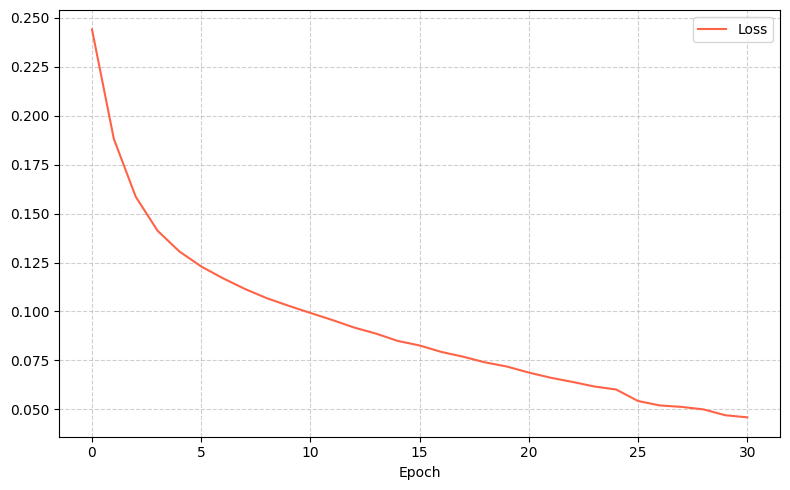

In [14]:
import numpy as np
history_loss = np.load(f'models/{MODEL_NAME}/{DATASET_VAR}/history_loss.npy')
plt.figure(figsize=(8, 5))
plt.plot(history_loss, linestyle='-', color='tomato', label="Loss")
# plt.title(title)
plt.xlabel("Epoch")
# plt.ylabel(ylabel)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
torch.cuda.empty_cache()
os.getpid()

10833